<a href="https://colab.research.google.com/github/RobbieEarle/siamese_net/blob/main/SiameseTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Model
Model is trained using signatures from 64 individuals. Each individual provides between 10 - 30 examples of their signature. 

We randomly select pairs of signatures, and the model attempts to predict whether both came from the same individual, or from two different individuals.

We can of course generate many more combinations of signatures from different individuals than we can from the same individual. To account for this we collect all possible pairs from the same individual, and then take a random sample from the space of all possible pairs from different individuals that is the same size. This ensures that our dataset is balanced (i.e. the model will see an equal number of positive and negative samples).

In [1]:
#@title Mounting google drive
from google.colab import drive
import os
import matplotlib.pyplot as plt

drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Siamese")
!ls

Mounted at /content/drive
SiameseTesting.ipynb  test_new	training_weights  train_new


In [13]:
#@title Defining Siamese network

import torch.nn as nn

#create a siamese network
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(1, 64, 10),  # 64@96*96
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2),  # 64@48*48
      nn.Conv2d(64, 128, 7),
      nn.ReLU(),    # 128@42*42
      nn.MaxPool2d(2),   # 128@21*21
      nn.Conv2d(128, 128, 4),
      nn.ReLU(), # 128@18*18
      nn.MaxPool2d(2), # 128@9*9
      nn.Conv2d(128, 256, 4),
      nn.ReLU(),   # 256@6*6
    )
    self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
    self.out = nn.Linear(4096, 1)

  def forward_one(self, x):
    x = self.conv(x)
    x = x.view(x.size()[0], -1)
    x = self.liner(x)
    return x

  def forward(self, x1, x2):
    out1 = self.forward_one(x1)
    out2 = self.forward_one(x2)
    dis = torch.abs(out1 - out2)
    out = self.out(dis)
    # return self.sigmoid(out)
    return out.squeeze()


    #   # Setting up the Sequential of CNN Layers
    #   self.cnn1 = nn.Sequential(
    #     nn.Conv2d(1, 96, kernel_size=11,stride=1),
    #     nn.ReLU(inplace=True),
    #     nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
    #     nn.MaxPool2d(3, stride=2),
        
    #     nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
    #     nn.ReLU(inplace=True),
    #     nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
    #     nn.MaxPool2d(3, stride=2),
    #     nn.Dropout2d(p=0.3),

    #     nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
    #     nn.ReLU(inplace=True),
        
    #     nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
    #     nn.ReLU(inplace=True),
    #     nn.MaxPool2d(3, stride=2),
    #     nn.Dropout2d(p=0.3),
    #   )
    #   # Defining the fully connected layers
    #   self.fc1 = nn.Sequential(
    #     nn.Linear(30976, 20),
    #     nn.Sigmoid()
    #   )

    #   self.fc_final = nn.Sequential(
    #     nn.Linear(20, 2),
    #     nn.Sigmoid()
    #   )
        
    # def forward_once(self, x):
    #   # Forward pass 
    #   output = self.cnn1(x)
    #   output = output.view(output.size()[0], -1)
    #   output = self.fc1(output)
    #   return output

    # def forward(self, x):
    #   x1 = x[0]
    #   x2 = x[1]

    #   x1 = self.forward_once(x1)
    #   x2 = self.forward_once(x2)

    #   x = torch.abs(x1 - x2)
    #   x = self.fc_final(x)
    #   return x

In [14]:
#@title Signature dataset loader

import torch
import torchvision.transforms as transforms
import numpy as np
import itertools
from IPython.display import HTML, display
import time
import random
from PIL import Image
import PIL.ImageOps
import os

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 35%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def load_signature_dataset(training_dir=None, percent_true=50, seed=None):
  # used to prepare the labels and images path

  assert percent_true < 100 and percent_true >= 1
  authors = os.listdir(training_dir)
  if '.DS_Store' in authors:
    authors.remove('.DS_Store')

  true_samples = []
  false_samples = []

  print("Loading samples:")
  out = display(progress(0, len(authors) - 1), display_id=True)
  for idx, author_dir in enumerate(authors):
    author_path = os.path.join(training_dir, author_dir)
    for pair in itertools.combinations(os.listdir(author_path), r=2):
      im1 = os.path.join(author_path, pair[0])
      im2 = os.path.join(author_path, pair[1])
      sample = [im1, im2, 1]
      true_samples.append(sample)
    for sig in os.listdir(author_path):
      im1 = os.path.join(author_path, sig)
      for author_dir2 in authors:
        if author_dir2 != author_dir:
          author_path2 = os.path.join(training_dir, author_dir2)
          for sig2 in os.listdir(author_path2):
            im2 = os.path.join(author_path2, sig2)
            sample = [im1, im2, 0]
            false_samples.append(sample)
    out.update(progress(idx, len(authors) - 1))

  num_true = len(true_samples)
  percent_false = 100 - percent_true
  num_false = percent_false * int(num_true / percent_true)
  if seed is not None:
    random.seed(seed)
  random.shuffle(true_samples)
  random.shuffle(false_samples)
  false_samples = false_samples[:num_false]
  samples = true_samples + false_samples
  random.shuffle(samples)

  print()
  print("Number true samples: {}".format(len(true_samples)))
  print("Number false samples: {}".format(len(false_samples)))
  print("Total samples: {}".format(len(samples)))

  return samples
  

class SiameseDataset():
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __getitem__(self,index):

        sample = self.samples[index]
        image1_path = sample[0]
        image2_path = sample[1]
        label = torch.from_numpy(np.array([sample[2]],dtype=np.float32)).type(torch.float)
        
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1 , label.squeeze()

    def __len__(self):
        return len(self.samples)


data_transforms = transforms.Compose([transforms.Resize((105,105)),
                                      transforms.ToTensor()
                                      ])

signature_dataset = load_signature_dataset(training_dir="train_new",
                                           percent_true=50,
                                           seed=42)

num_samples = len(signature_dataset)
train_set = SiameseDataset(signature_dataset[:int(0.8 *num_samples)],
                           transform=data_transforms)
val_set = SiameseDataset(signature_dataset[int(0.8 *num_samples):int(0.9 *num_samples)],
                         transform=data_transforms)
test_set = SiameseDataset(signature_dataset[int(0.9 *num_samples):],
                          transform=data_transforms)

print()
print("Train set: {} samples".format(len(train_set)))
print("Validation set: {} samples".format(len(val_set)))
print("Test set: {} samples".format(len(test_set)))

bs = 20
train_loader = torch.utils.data.DataLoader(train_set,
                                           shuffle=True,
                                           batch_size=bs,
                                           drop_last=True)
val_loader = torch.utils.data.DataLoader(val_set,
                                         shuffle=True,
                                         batch_size=bs)
test_loader = torch.utils.data.DataLoader(test_set,
                                          shuffle=True,
                                          batch_size=1)

Loading samples:



Number true samples: 6301
Number false samples: 6300
Total samples: 12601

Train set: 10080 samples
Validation set: 1260 samples
Test set: 1261 samples


Labels:  tensor([0., 1., 1., 0., 1.])



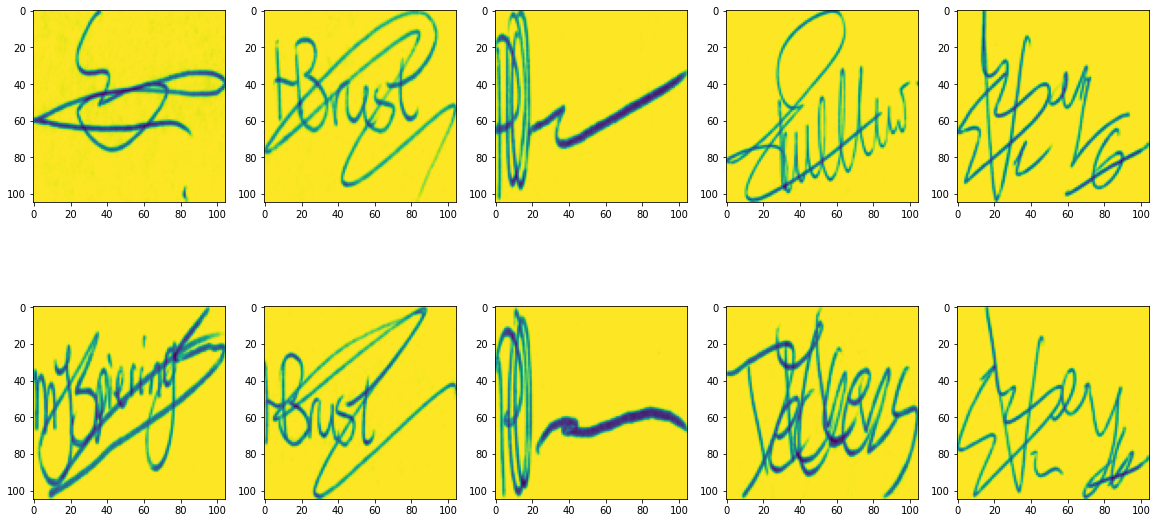

In [ ]:
#@title Generating random batch sample
#@markdown Each column represents a sample. Label 1 indicates signatures are from
#@markdown the same person, label 2 indicates signatures are from two different people

fig, axs = plt.subplots(2, 5, figsize=(20,10))

for (x1, x2, targetx) in train_loader:
  for i in range(5):
    img1 = x1[i].squeeze(0)
    img2 = x2[i].squeeze(0)
    axs[0][i].imshow(img1.numpy())
    axs[1][i].imshow(img2.numpy())
  print("Labels: ", targetx[:5])
  print()
  break

In [ ]:
#@title Model training script

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
%matplotlib inline

def train_model(output_dir=None, label=None, epochs=100, wd=0):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  model = SiameseNetwork().to(device)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.00006, weight_decay=wd)

  print("Running...")

  tz = timezone('Canada/Atlantic')
  train_date = str(datetime.now(tz).strftime('%H_%M-%Y_%m_%d'))
  best_val_acc = None
  for epoch in range(epochs):
    start_time = time.time()
    model.train()
    total_train_loss, n, sse, num_correct, num_total = 0, 0, 0, 0, 0

    for batch_idx, (x1, x2, targetx) in enumerate(train_loader):
      x1, x2, targetx = x1.to(device), x2.to(device), targetx.to(device)
      optimizer.zero_grad()
      output = model(x1, x2)
      train_loss = criterion(output, targetx)
      train_loss.backward()
      optimizer.step()

      total_train_loss += train_loss
      output = torch.sigmoid(output)
      prediction = torch.round(output)
      num_correct += torch.sum(prediction == targetx)
      num_total += len(output)
      n += 1
      # if (batch_idx + 1) % 50 == 0:
      #   print("Batch {}: Loss {}, {}/20".format(batch_idx, train_loss, torch.sum(prediction == targetx)))

    train_loss = total_train_loss / n
    train_acc = num_correct * 1.0 / num_total

    model.eval()
    with torch.no_grad():
      total_val_loss, n, sse, num_correct, num_total = 0, 0, 0, 0, 0
      for batch_idx, (y1, y2, targety) in enumerate(val_loader):
        y1, y2, targety = y1.to(device), y2.to(device), targety.to(device)
        output = model(y1, y2)

        val_loss = criterion(output, targety)
        total_val_loss += val_loss
        output = torch.sigmoid(output)
        prediction = torch.round(output)
        num_correct += torch.sum(prediction == targety)
        num_total += len(output)
        n += 1

      val_loss = total_val_loss / n
      val_acc = num_correct * 1.0 / num_total

      lr_curr = 0
      for param_group in optimizer.param_groups:
        lr_curr = param_group['lr']

      print("Epoch:{:>4d}/{:>4d} | LR ={:8.5f} | train_loss ={:8.5f}, train_acc ={:7.3f}% | val_loss ={:8.5f}, val_acc ={:7.3f}% | time = {:6.3f}s".format(
          epoch + 1, epochs, lr_curr, train_loss, train_acc * 100, val_loss, val_acc * 100, time.time() - start_time))

      improved_acc = False
      if best_val_acc is not None:
        improved_acc = val_acc > best_val_acc
      if output_dir is not None and (improved_acc or best_val_acc is None):
        if output_dir is not None:
          if label is not None:
            save_path = os.path.join(output_dir, "{}-{}".format(label, train_date))
          else:
            save_path = os.path.join(output_dir, train_date)
        torch.save(model.state_dict(), save_path)
        best_val_acc = val_acc

In [ ]:
train_model(output_dir="training_weights", label="wd4", wd=1e-4)

Running...
Epoch:   1/ 100 | LR = 0.00006 | train_loss = 0.56904, train_acc = 62.490% | val_loss = 0.45018, val_acc = 76.587% | time = 95.081s
Epoch:   2/ 100 | LR = 0.00006 | train_loss = 0.39211, train_acc = 82.778% | val_loss = 0.33588, val_acc = 85.635% | time = 95.451s
Epoch:   3/ 100 | LR = 0.00006 | train_loss = 0.26227, train_acc = 90.129% | val_loss = 0.25037, val_acc = 91.667% | time = 95.495s
Epoch:   4/ 100 | LR = 0.00006 | train_loss = 0.16899, train_acc = 94.157% | val_loss = 0.17668, val_acc = 93.968% | time = 95.766s
Epoch:   5/ 100 | LR = 0.00006 | train_loss = 0.10581, train_acc = 96.796% | val_loss = 0.12628, val_acc = 95.714% | time = 96.401s
Epoch:   6/ 100 | LR = 0.00006 | train_loss = 0.06490, train_acc = 98.353% | val_loss = 0.12051, val_acc = 95.714% | time = 95.893s
Epoch:   7/ 100 | LR = 0.00006 | train_loss = 0.03558, train_acc = 99.395% | val_loss = 0.08906, val_acc = 97.143% | time = 95.110s
Epoch:   8/ 100 | LR = 0.00006 | train_loss = 0.02063, train_acc 

# Testing Model

### Generalizing to new signatures from the same signatories
The signatures used for testing here were written by the same 64 individuals from the training session, but are examples/instances that were purposefully held out of the training data set.

Running...
total=1, tp=1, tn=0, fp=0, fn=0
total=11, tp=8, tn=3, fp=0, fn=0
total=21, tp=14, tn=7, fp=0, fn=0
False Positive: 0.72962486743927 predicted probability


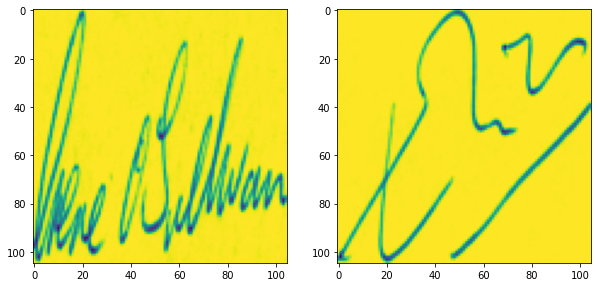

total=31, tp=20, tn=10, fp=1, fn=0
total=41, tp=25, tn=15, fp=1, fn=0
total=51, tp=30, tn=20, fp=1, fn=0
total=61, tp=36, tn=24, fp=1, fn=0
total=71, tp=41, tn=29, fp=1, fn=0
total=81, tp=45, tn=35, fp=1, fn=0
total=91, tp=46, tn=44, fp=1, fn=0
False Positive: 0.5749045610427856 predicted probability


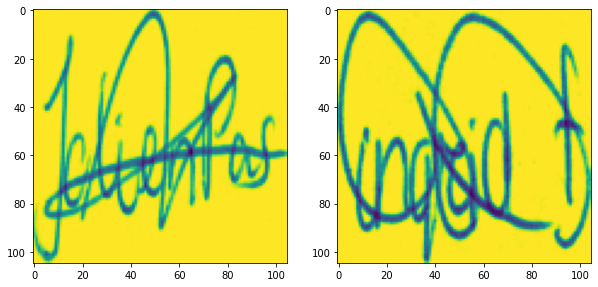

total=101, tp=48, tn=51, fp=2, fn=0
total=111, tp=55, tn=54, fp=2, fn=0
total=121, tp=59, tn=60, fp=2, fn=0
total=131, tp=66, tn=63, fp=2, fn=0
total=141, tp=74, tn=65, fp=2, fn=0
total=151, tp=80, tn=69, fp=2, fn=0
total=161, tp=85, tn=74, fp=2, fn=0
False Positive: 0.923086941242218 predicted probability


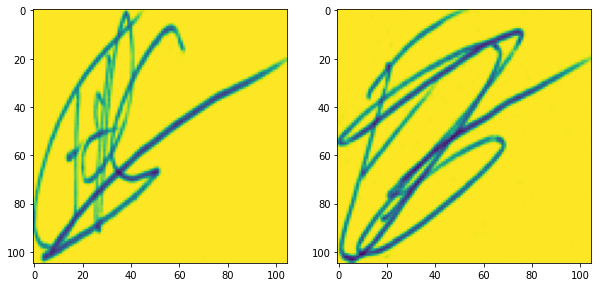

total=171, tp=88, tn=80, fp=3, fn=0
total=181, tp=92, tn=86, fp=3, fn=0
False Positive: 0.9233123064041138 predicted probability


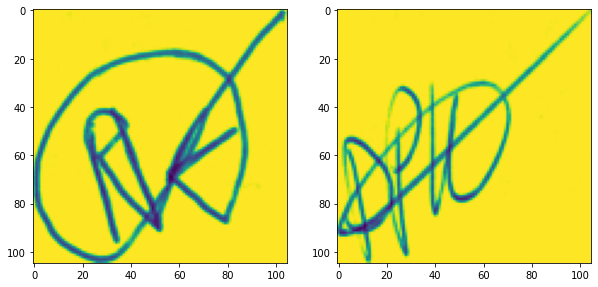

total=191, tp=97, tn=90, fp=4, fn=0
total=201, tp=102, tn=95, fp=4, fn=0
total=211, tp=107, tn=100, fp=4, fn=0
total=221, tp=113, tn=104, fp=4, fn=0
total=231, tp=117, tn=110, fp=4, fn=0
total=241, tp=124, tn=113, fp=4, fn=0
total=251, tp=126, tn=121, fp=4, fn=0
total=261, tp=132, tn=125, fp=4, fn=0
total=271, tp=140, tn=127, fp=4, fn=0
total=281, tp=145, tn=132, fp=4, fn=0
total=291, tp=149, tn=138, fp=4, fn=0
total=301, tp=154, tn=143, fp=4, fn=0
total=311, tp=157, tn=150, fp=4, fn=0
total=321, tp=161, tn=156, fp=4, fn=0
total=331, tp=164, tn=163, fp=4, fn=0
total=341, tp=168, tn=169, fp=4, fn=0
total=351, tp=173, tn=174, fp=4, fn=0
total=361, tp=179, tn=178, fp=4, fn=0
total=371, tp=185, tn=182, fp=4, fn=0
total=381, tp=190, tn=187, fp=4, fn=0
total=391, tp=196, tn=191, fp=4, fn=0
total=401, tp=198, tn=199, fp=4, fn=0
total=411, tp=204, tn=203, fp=4, fn=0
total=421, tp=210, tn=207, fp=4, fn=0
total=431, tp=216, tn=211, fp=4, fn=0
total=441, tp=221, tn=216, fp=4, fn=0
total=451, tp=2

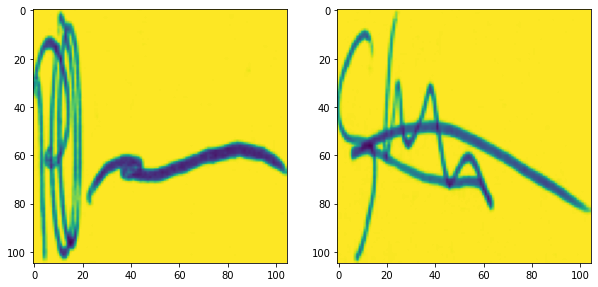

total=531, tp=268, tn=258, fp=5, fn=0
total=541, tp=274, tn=262, fp=5, fn=0
total=551, tp=275, tn=271, fp=5, fn=0
False Positive: 0.9758895635604858 predicted probability


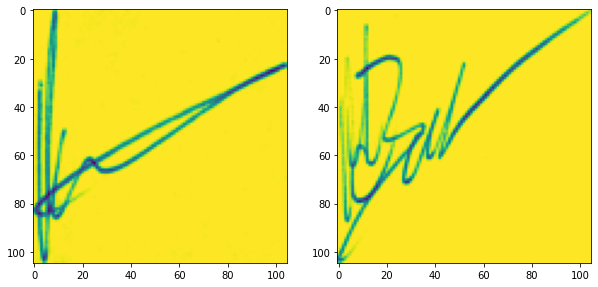

total=561, tp=278, tn=277, fp=6, fn=0
total=571, tp=282, tn=283, fp=6, fn=0
total=581, tp=287, tn=288, fp=6, fn=0
False Positive: 0.5712472200393677 predicted probability


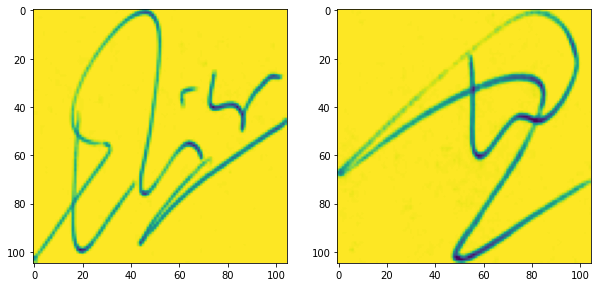

total=591, tp=293, tn=291, fp=7, fn=0
total=601, tp=299, tn=295, fp=7, fn=0
total=611, tp=307, tn=297, fp=7, fn=0
total=621, tp=310, tn=304, fp=7, fn=0
total=631, tp=316, tn=308, fp=7, fn=0
total=641, tp=322, tn=312, fp=7, fn=0
total=651, tp=329, tn=315, fp=7, fn=0
total=661, tp=332, tn=322, fp=7, fn=0
total=671, tp=334, tn=330, fp=7, fn=0
total=681, tp=339, tn=335, fp=7, fn=0
total=691, tp=343, tn=341, fp=7, fn=0
total=701, tp=350, tn=344, fp=7, fn=0
total=711, tp=354, tn=350, fp=7, fn=0
total=721, tp=359, tn=355, fp=7, fn=0
False Positive: 0.9966723918914795 predicted probability


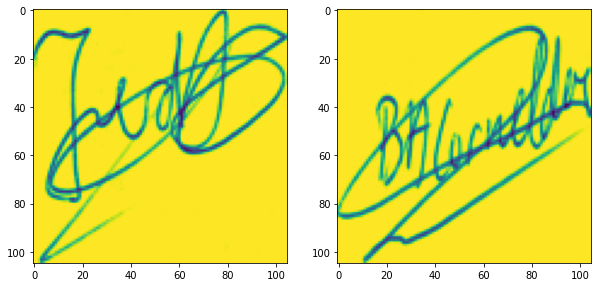

total=731, tp=362, tn=361, fp=8, fn=0
total=741, tp=365, tn=368, fp=8, fn=0
False Positive: 0.875944972038269 predicted probability


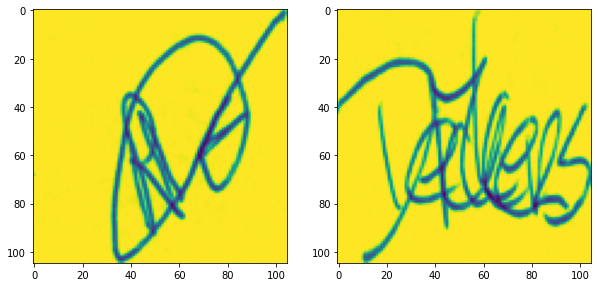

total=751, tp=368, tn=374, fp=9, fn=0
False Positive: 0.5506787896156311 predicted probability


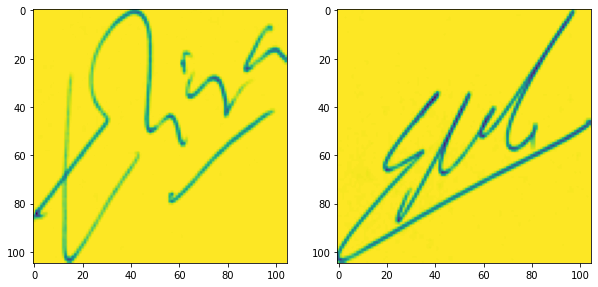

False Positive: 0.8777737617492676 predicted probability


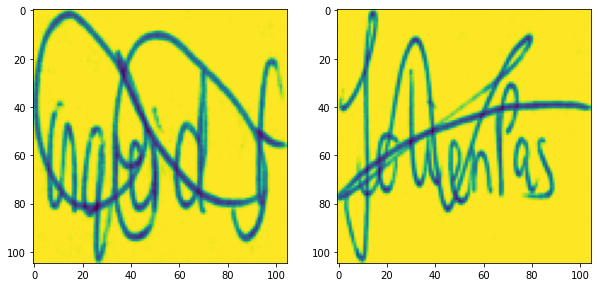

total=761, tp=370, tn=380, fp=11, fn=0
total=771, tp=375, tn=385, fp=11, fn=0
total=781, tp=378, tn=392, fp=11, fn=0
False Positive: 0.7079837918281555 predicted probability


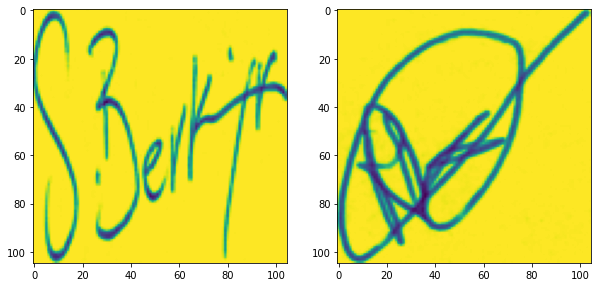

total=791, tp=381, tn=398, fp=12, fn=0
False Positive: 0.8807888031005859 predicted probability


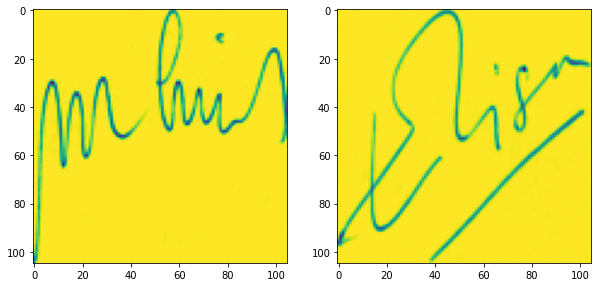

total=801, tp=384, tn=404, fp=13, fn=0
total=811, tp=389, tn=409, fp=13, fn=0
total=821, tp=393, tn=415, fp=13, fn=0
total=831, tp=395, tn=423, fp=13, fn=0
total=841, tp=402, tn=426, fp=13, fn=0
total=851, tp=407, tn=431, fp=13, fn=0
total=861, tp=412, tn=436, fp=13, fn=0
False Positive: 0.9362882375717163 predicted probability


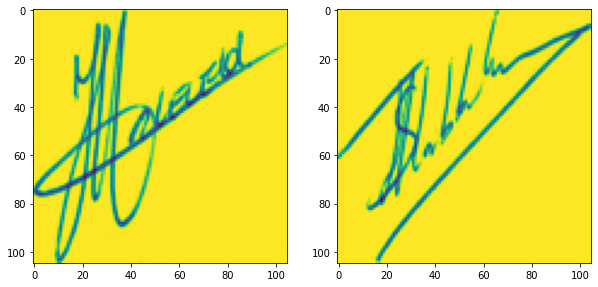

total=871, tp=417, tn=440, fp=14, fn=0
total=881, tp=425, tn=442, fp=14, fn=0
total=891, tp=431, tn=446, fp=14, fn=0
total=901, tp=436, tn=451, fp=14, fn=0
total=911, tp=443, tn=454, fp=14, fn=0
total=921, tp=449, tn=458, fp=14, fn=0
total=931, tp=455, tn=462, fp=14, fn=0
total=941, tp=460, tn=467, fp=14, fn=0
total=951, tp=462, tn=475, fp=14, fn=0
total=961, tp=465, tn=482, fp=14, fn=0
total=971, tp=468, tn=489, fp=14, fn=0
False Positive: 0.6877738833427429 predicted probability


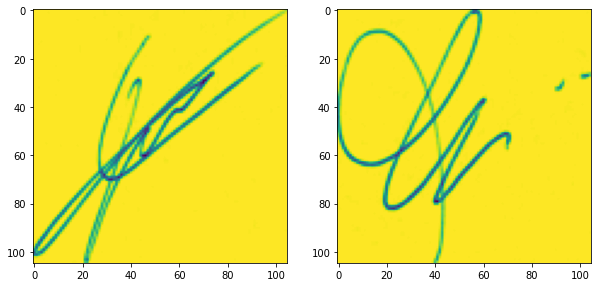

total=981, tp=469, tn=497, fp=15, fn=0
total=991, tp=477, tn=499, fp=15, fn=0
total=1001, tp=480, tn=506, fp=15, fn=0
total=1011, tp=487, tn=509, fp=15, fn=0
total=1021, tp=493, tn=513, fp=15, fn=0
total=1031, tp=496, tn=520, fp=15, fn=0
total=1041, tp=500, tn=526, fp=15, fn=0
total=1051, tp=507, tn=529, fp=15, fn=0
total=1061, tp=510, tn=536, fp=15, fn=0
total=1071, tp=517, tn=539, fp=15, fn=0
total=1081, tp=520, tn=546, fp=15, fn=0
False Negative: 0.2995423972606659 predicted probability


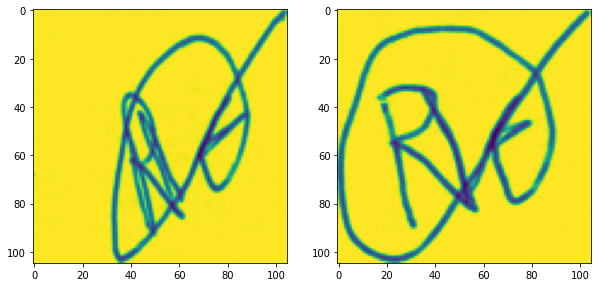

total=1091, tp=523, tn=552, fp=15, fn=1
total=1101, tp=528, tn=557, fp=15, fn=1
total=1111, tp=530, tn=565, fp=15, fn=1
total=1121, tp=536, tn=569, fp=15, fn=1
total=1131, tp=539, tn=576, fp=15, fn=1
total=1141, tp=544, tn=581, fp=15, fn=1
False Positive: 0.9996129870414734 predicted probability


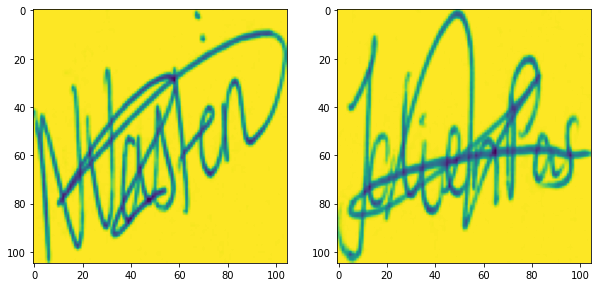

total=1151, tp=546, tn=588, fp=16, fn=1
total=1161, tp=551, tn=593, fp=16, fn=1
total=1171, tp=556, tn=598, fp=16, fn=1
total=1181, tp=561, tn=603, fp=16, fn=1
total=1191, tp=564, tn=610, fp=16, fn=1
total=1201, tp=572, tn=612, fp=16, fn=1
total=1211, tp=575, tn=619, fp=16, fn=1
total=1221, tp=576, tn=628, fp=16, fn=1
total=1231, tp=578, tn=636, fp=16, fn=1
False Positive: 0.7660019993782043 predicted probability


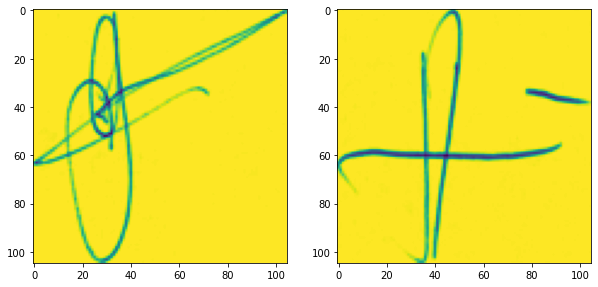

total=1241, tp=582, tn=641, fp=17, fn=1
total=1251, tp=588, tn=645, fp=17, fn=1
total=1261, tp=590, tn=653, fp=17, fn=1


FINAL: total=1261, tp=590, tn=653, fp=17, fn=1


In [21]:
#@title Populating confusion matrix

def print_sample(y1, y2):
  fig, axs = plt.subplots(1, 2, figsize=(10,5), squeeze=False)
  img1 = y1.squeeze()
  img2 = y2.squeeze()
  axs[0][0].imshow(img1.numpy())
  axs[0][1].imshow(img2.numpy())
  plt.show()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = SiameseNetwork().to(device)
model.load_state_dict(torch.load('training_weights/98_889-wd4-23_53-2021_06_13', map_location=torch.device(device)))

print("Running...")
model.eval()
with torch.no_grad():
  tp, tn, fp, fn, total = 0, 0, 0, 0, 0
  for batch_idx, (y1, y2, targety) in enumerate(test_loader):
    y1, y2, targety = y1.to(device), y2.to(device), targety.to(device)
    output = model(y1, y2)
    output = torch.sigmoid(output)
    prediction = torch.round(output)

    total += 1
    if prediction == 1 and targety == 1:
      tp += 1
    elif prediction == 0 and targety == 0:
      tn += 1
    elif prediction == 1 and targety == 0:
      fp += 1
      print("False Positive: {} predicted probability".format(output))
      print_sample(y1,y2)
    elif prediction == 0 and targety == 1:
      fn += 1
      print("False Negative: {} predicted probability".format(output))
      print_sample(y1,y2)

    if batch_idx % 10 == 0:
      print("total={}, tp={}, tn={}, fp={}, fn={}".format(total, tp, tn, fp, fn))

  print("\n============================================\n")
  print("FINAL: total={}, tp={}, tn={}, fp={}, fn={}".format(total, tp, tn, fp, fn))

Precision = 0.972

Recall = 0.998

### Generalizing to new signatures from new signatories
The signatures used for training here were written by 21 brand new people, separate from the 64 used during training. Each again provided between 10 - 30 examples of their signature, and this data set was again balanced to have an equal number of positive and negative samples.